# Topic extraction

Using `tomotopy`'s LDA implementation.
Comparing different token weighings — nominal, IDF, and PMI (Pointwise Mutual Information) in terms of topic coherence.

In [1]:
import psycopg2
import numpy
from time import time
import nltk
import wordcloud
import matplotlib.pyplot as plt
import gensim

n_samples = 200000
n_iterations = 1000

In [2]:
def log(message):
    print(message, flush=True)

In [3]:
t0 = time()
print("Connecting to DB...")
conn = psycopg2.connect("dbname='peanut_prod' user='mezis' host='frolic.local' password='av85ck4g'")
cur = conn.cursor()

print("Loading dataset...")
cur.execute(f"""
    SELECT CONCAT_WS(' ', title, body) AS text
    FROM post p
    JOIN users u ON u.id = p.author_id
    --JOIN post_stats ps ON ps.id = p.id AND ps.view_count > 50
    WHERE TRUE
      AND u.account_status = 'active'
      AND p.status = 'active'
    ORDER BY p.id DESC
    LIMIT {n_samples}
""")
data_samples = [row[0] for row in cur.fetchall()]

print("done in %0.3fs." % (time() - t0))
print("%d samples" % len(data_samples))

Connecting to DB...
Loading dataset...
done in 0.987s.
200000 samples


In [4]:
print("Preparing text preprocessing...")
import re

t0 = time()
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

class MyPreprocessor:
    def __call__(self, doc):
        return doc.lower()

class MyTokenizer:
    def __init__(self):
        self.wnl = nltk.stem.WordNetLemmatizer()
        self.stopwords = frozenset(
            nltk.corpus.stopwords.words('english') + """
                n't
                anyone
                everyone
                feel like want get
            """.split()
        )
        self.re = re.compile(r"[a-z0-9]")
        
    def __call__(self, doc):
        return [token for token in [self.filter(token) for token in self.tokenize(doc)] if token]
    
    def tokenize(self, doc):
        return nltk.word_tokenize(doc.lower());
    
    def filter(self, token):
        if token in self.stopwords:
            return
        if not self.re.match(token):
            return
        return self.wnl.lemmatize(token)

print("done in %0.3fs." % (time() - t0))

Preparing text preprocessing...
done in 0.122s.


[nltk_data] Downloading package punkt to /home/mezis/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/mezis/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /home/mezis/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/mezis/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [5]:
from tqdm import tqdm
import multiprocessing

print('Tokenizing...')
tokenizer = MyTokenizer()
data_tokenized = []
pool = multiprocessing.Pool(processes=8)
for tokenized in pool.imap_unordered(tokenizer, tqdm(data_samples)):
    data_tokenized.append(tokenized)
    
print("Building gensim corpus...")
gensim_dictionary = gensim.corpora.Dictionary(data_tokenized)

Tokenizing...


100%|██████████| 200000/200000 [00:30<00:00, 6495.95it/s]


Building gensim corpus...


In [6]:
import tomotopy as tp

model0 = tp.LDAModel(
    tw=tp.TermWeight.ONE,
    k=20, 
    min_cf=200,
    alpha=(1./len(data_samples)),
    eta=(1./len(data_samples)),
    seed=0
)

model1 = tp.LDAModel(
    tw=tp.TermWeight.IDF,
    k=20, 
    min_cf=200,
    alpha=(1./len(data_samples)),
    eta=(1./len(data_samples)),
    seed=0
)

model2 = tp.LDAModel(
    tw=tp.TermWeight.PMI,
    k=20, 
    min_cf=200,
    alpha=(1./len(data_samples)),
    eta=(1./len(data_samples)),
    seed=0
)

models = [model0, model1, model2]

for tokens in tqdm(data_tokenized):
    for m in models:
        m.add_doc(tokens)

100%|██████████| 200000/200000 [00:08<00:00, 24906.29it/s]


In [7]:
for i, model in enumerate(models):
    log(f'Training model {i}')
    for iter in tqdm(range(0, n_iterations)):
        model.train(1)

Training model 0


100%|██████████| 1000/1000 [04:01<00:00,  4.14it/s]

Training model 1



100%|██████████| 1000/1000 [04:44<00:00,  3.52it/s]

Training model 2



100%|██████████| 1000/1000 [05:59<00:00,  2.78it/s]


In [8]:
%config InlineBackend.figure_format = 'retina'

def make_wordcloud(data, n_words=50, w=400, h=300):

    return wordcloud.WordCloud(
        width = w, height = h, 
        background_color = 'white',
        prefer_horizontal = 1,
        relative_scaling = 0.1,
        min_font_size = h/40
    ).generate_from_frequencies(data) 

def render_clouds(model, n_words=50):
    fig=plt.figure(figsize=(16, 12))
    columns = 5
    rows = 4
    
    words = {} # topic idx -> word -> frequency
    for i in range(0, columns*rows):
        words[i] = dict(model.get_topic_words(i, top_n=n_words))

    images = {} # topic idx -> image
    for i in range(0, columns*rows):        
        images[i] = make_wordcloud(words[i])
    
    for i in range(0, columns*rows):
        img = images[i]
        subp = fig.add_subplot(rows, columns, i+1)
        subp.set_title("Topic #%d" % (i,))
#         subp.set_title("Topic #%d (%d%% posts)" % (i, 100 * counts[i] / counts.sum()))
        plt.imshow(img)
        plt.axis("off")
        plt.tight_layout(pad = 3.0)
    plt.show()

In [9]:
# https://towardsdatascience.com/dont-be-afraid-of-nonparametric-topic-models-part-2-python-e5666db347a
# https://github.com/ecoronado92/towards_data_science/blob/master/hdp_example/scripts/model_funcs.py

def get_topic_words(model, top_n=10):
    '''Wrapper function to extract topics from trained tomotopy HDP model 
    
    ** Inputs **
    model:obj -> trained model
    top_n: int -> top n words in topic based on frequencies
    
    ** Returns **
    topics: dict -> per topic, an arrays with top words and associated frequencies 
    '''
    
    # Get most important topics by # of times they were assigned (i.e. counts)
    sorted_topics = range(model.k)
    
    topics=dict()
    
    # For topics found, extract only those that are still assigned
    for k in sorted_topics:
        try:
            if not model.is_live_topic(k): continue # remove un-assigned topics at the end (i.e. not alive)
        except AttributeError: 
            pass
        
        topic_wp = model.get_topic_words(k, top_n=top_n)

        topics[k] = topic_wp # store topic word/frequency array
        
    return topics



def eval_coherence(topics_dict, vocab, documents, coherence_type='c_v'):
    '''Wrapper function that uses gensim Coherence Model to compute topic coherence scores
    
    ** Inputs **
    topic_dict: dict -> topic dictionary from train_HDPmodel function
    vocab: gensim.corpora.Dictionary
    documents: list of list of strings
    coherence_typ: str -> type of coherence value to comput (see gensim for opts)
    
    ** Returns **
    3-tuple,
        float -> coherence value
        float list -> per-topic coherence
        float list -> per-topic coherence deviation
    '''
    
    # Build topic list from dictionary
    topic_list=[]
    for k, tups in topics_dict.items():
        topic_tokens = [w for w,p in tups]
        topic_list.append(topic_tokens)
            

    # Build Coherence model
    cm = gensim.models.CoherenceModel(
        topics=topic_list,
        dictionary=vocab,
        texts=documents, 
        coherence=coherence_type,
        processes=8)
    
    score = cm.get_coherence()
    score_per_topic = cm.get_coherence_per_topic(with_std=True)
    return (
        score,
        [x for x,y in score_per_topic],
        [y for x,y in score_per_topic],
    )


In [10]:
#
# FIXME:
# only consider a topic when its score is > some threshold (2x 1/20 ?)

def topic_counts(model, top_n):
    """For each topic, count posts where the topic figure in the `top_n` topics
    
    Returns:
    dict of topic_id (int), posts (int)
    """
    counts = {}
    threshold = 2.0 / model.k
    for k in range(model.k):
        counts[k] = 0
    for doc in tqdm(model.docs):
        for k, v in doc.get_topics(top_n=top_n):
            if v < threshold: next
            counts[k] += 1
    return counts

In [11]:
def plot_analysis(model, coherence, axes):
    c1 = topic_counts(model, top_n=1)
    c3 = topic_counts(model, top_n=3)

    rows = 3
    
    axes[0].bar(c1.keys(), c1.values())
    axes[0].set_xticks(list(c1.keys()))
    axes[0].grid()
    axes[0].set_title('Posts per topic (top-1 topic)')

    axes[1].bar(c3.keys(), c3.values())
    axes[1].set_xticks(list(c3.keys()))
    axes[1].grid()
    axes[1].set_title('Posts per topic (top-3 topic)')

    x = range(len(coherence[1]))
    axes[2].bar(
        x,
        coherence[1],
        yerr=coherence[2])
    axes[2].set_xticks(x)
    axes[2].grid()
    axes[2].set_title('Per-topic coherence')

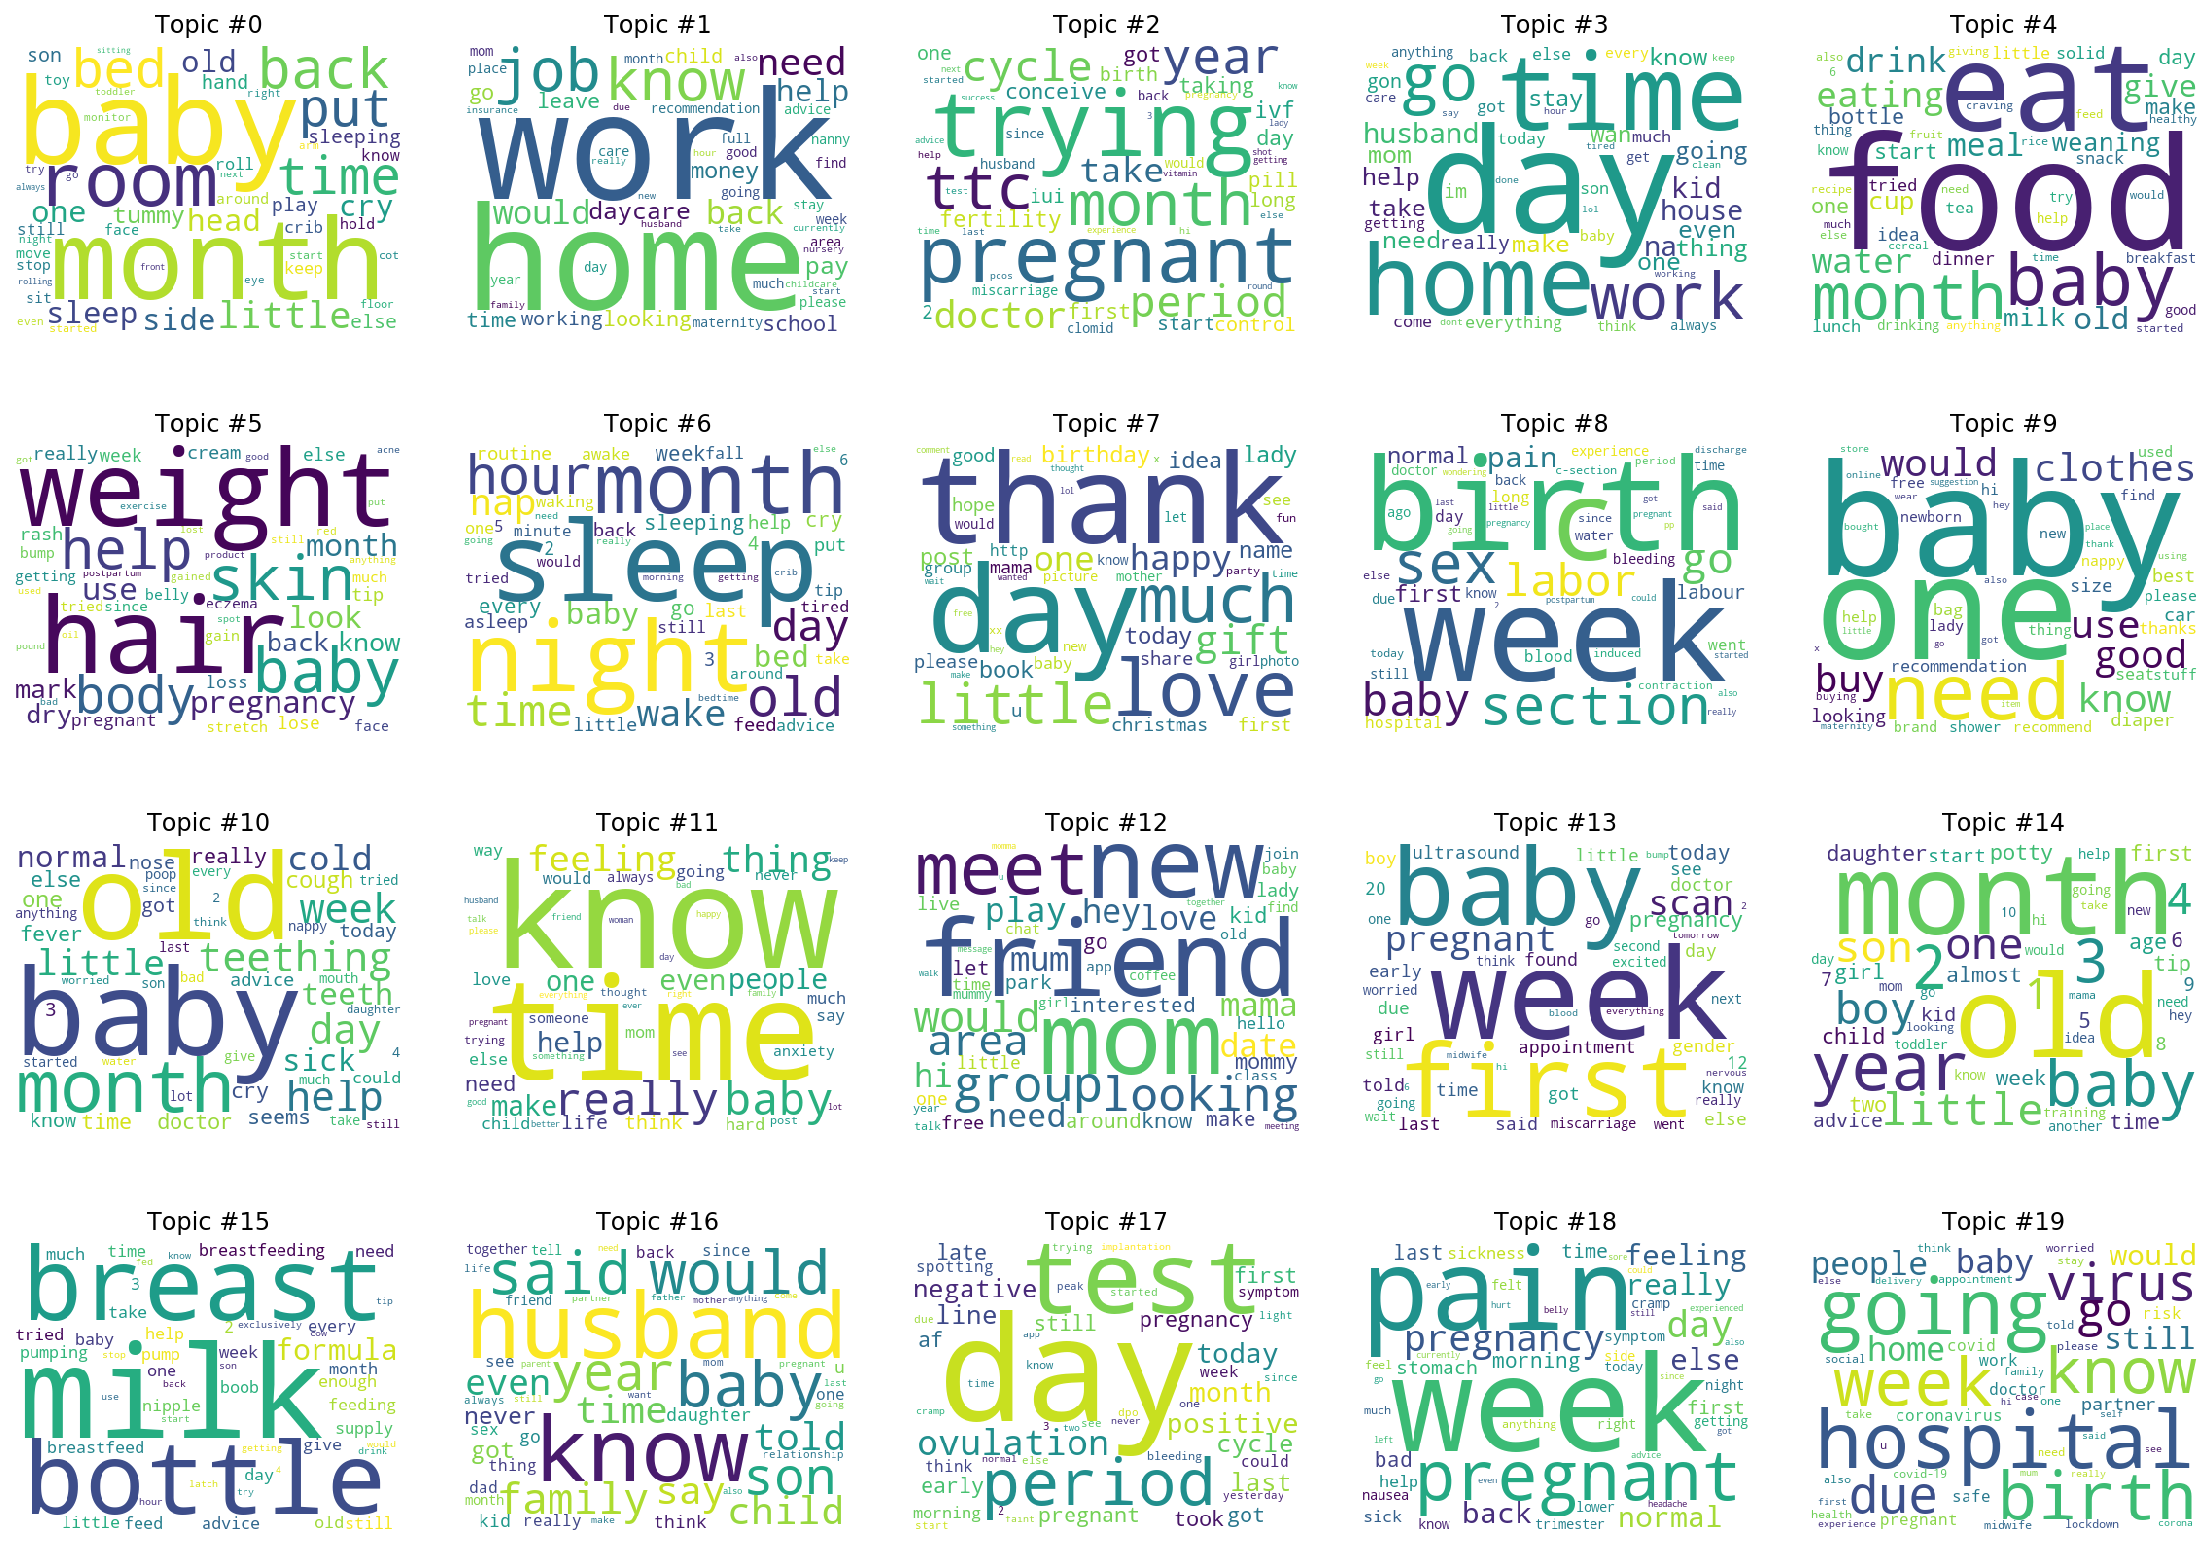

In [12]:
render_clouds(model0)

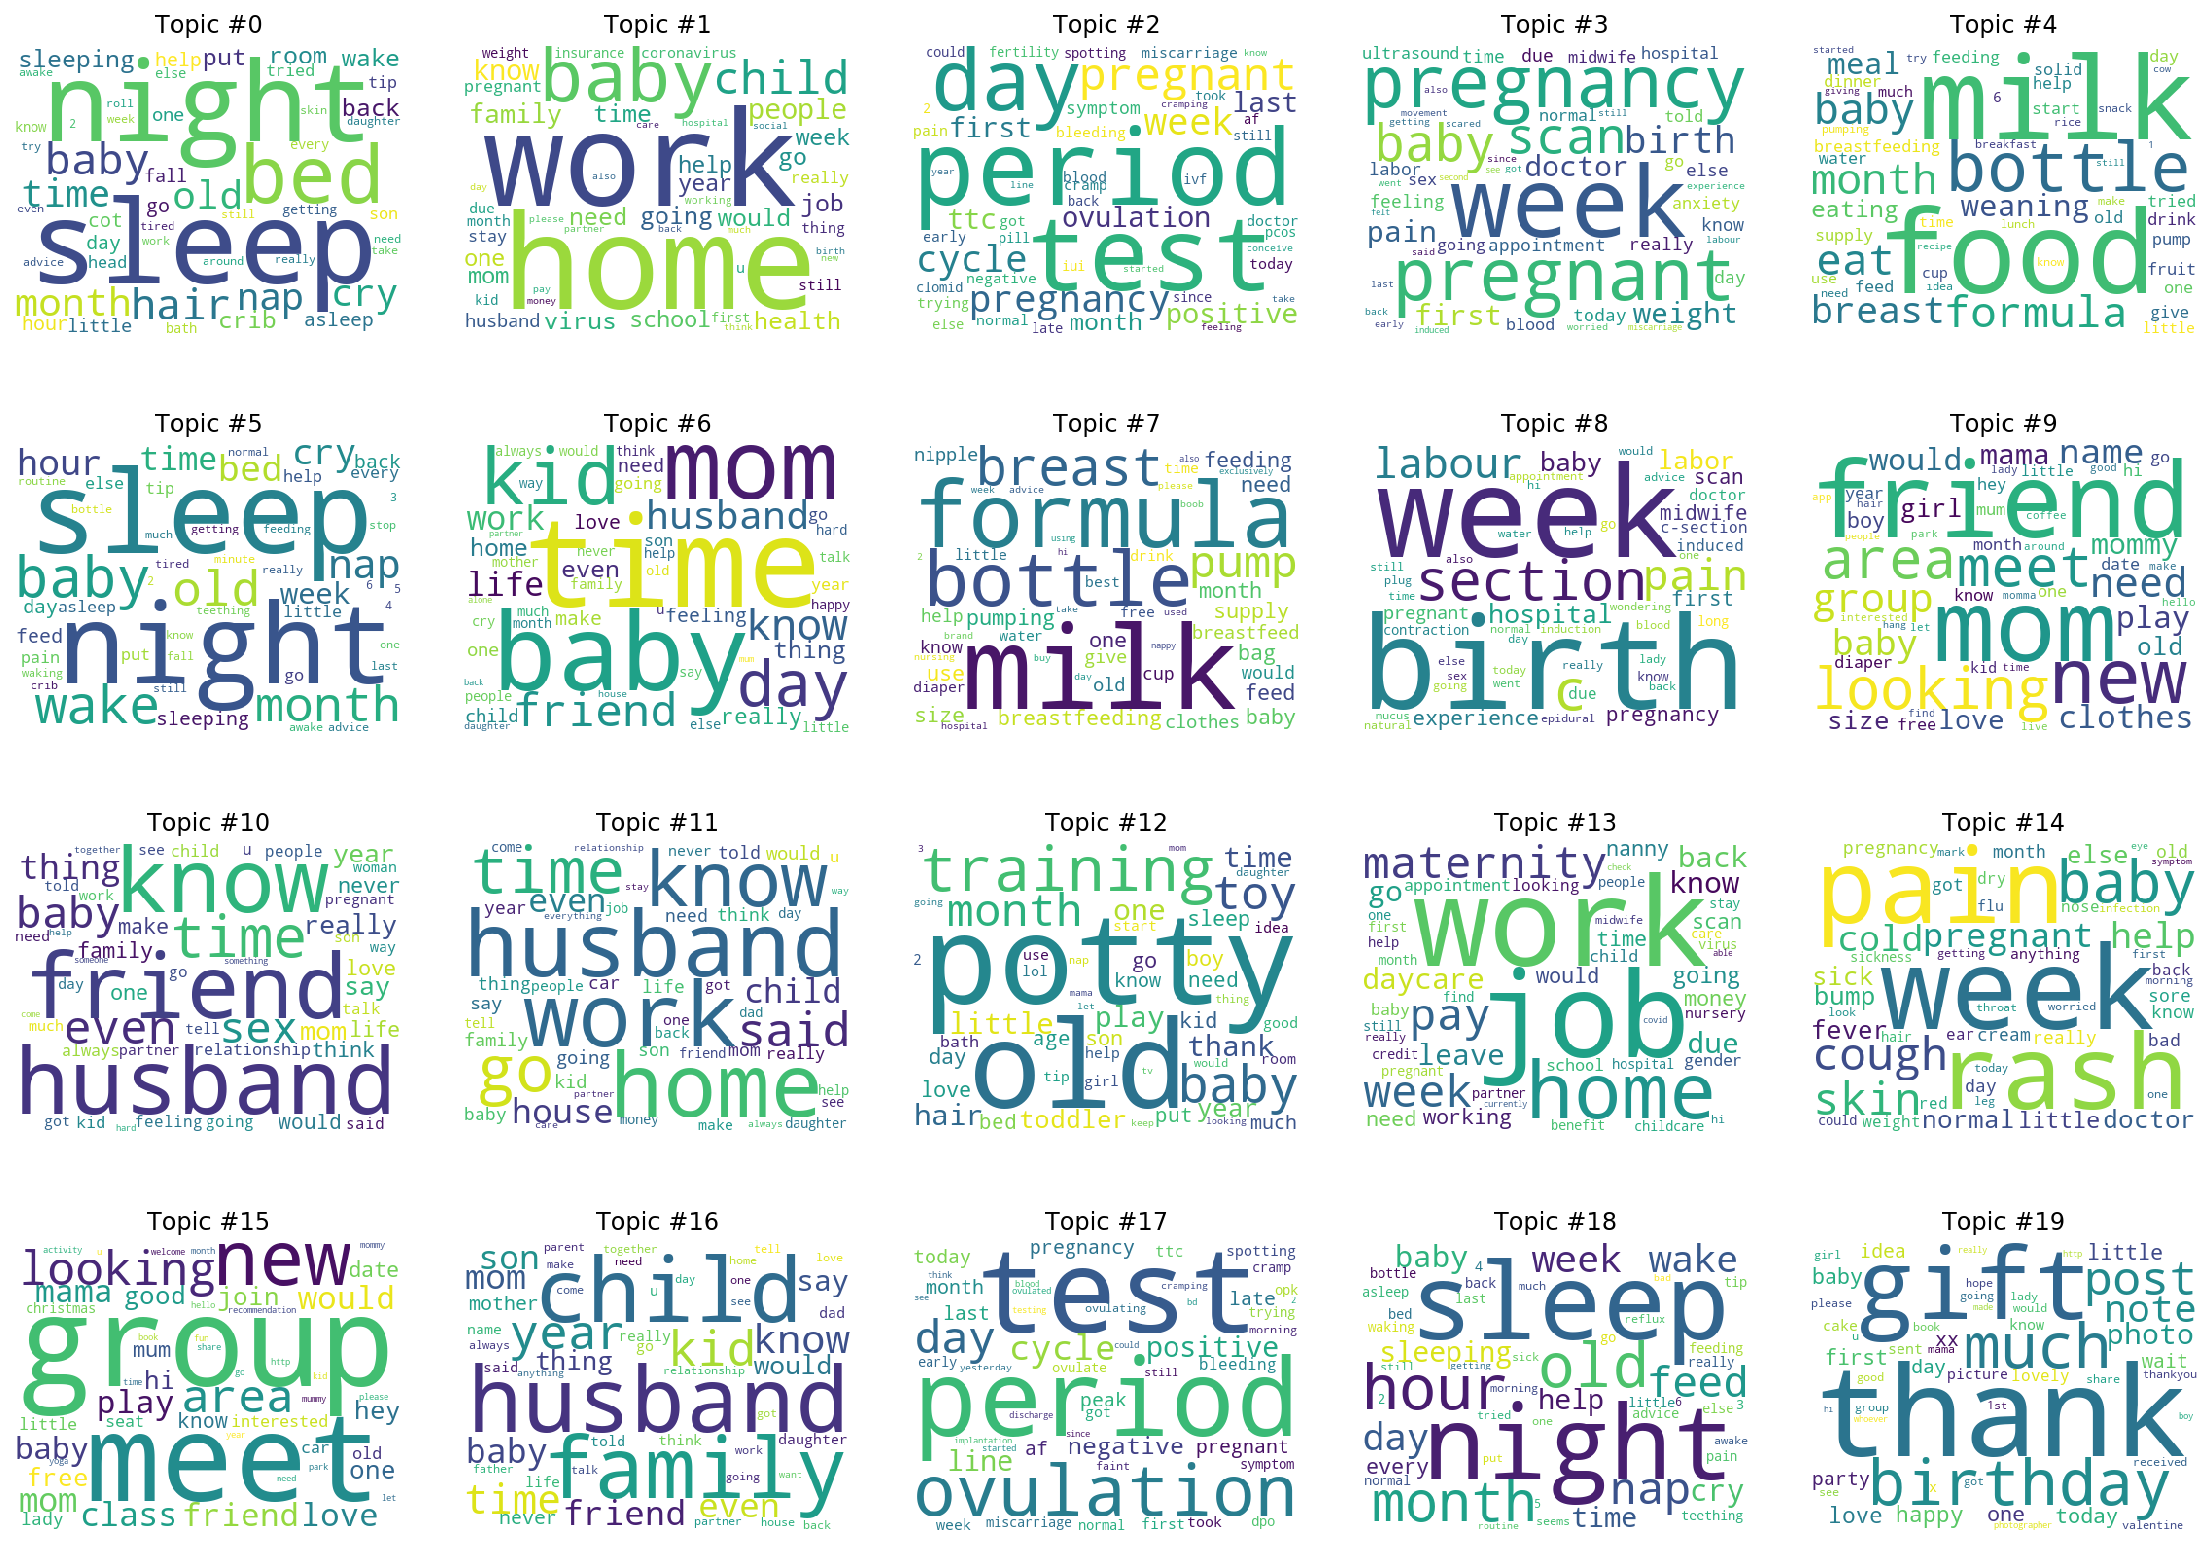

In [13]:
render_clouds(model1)

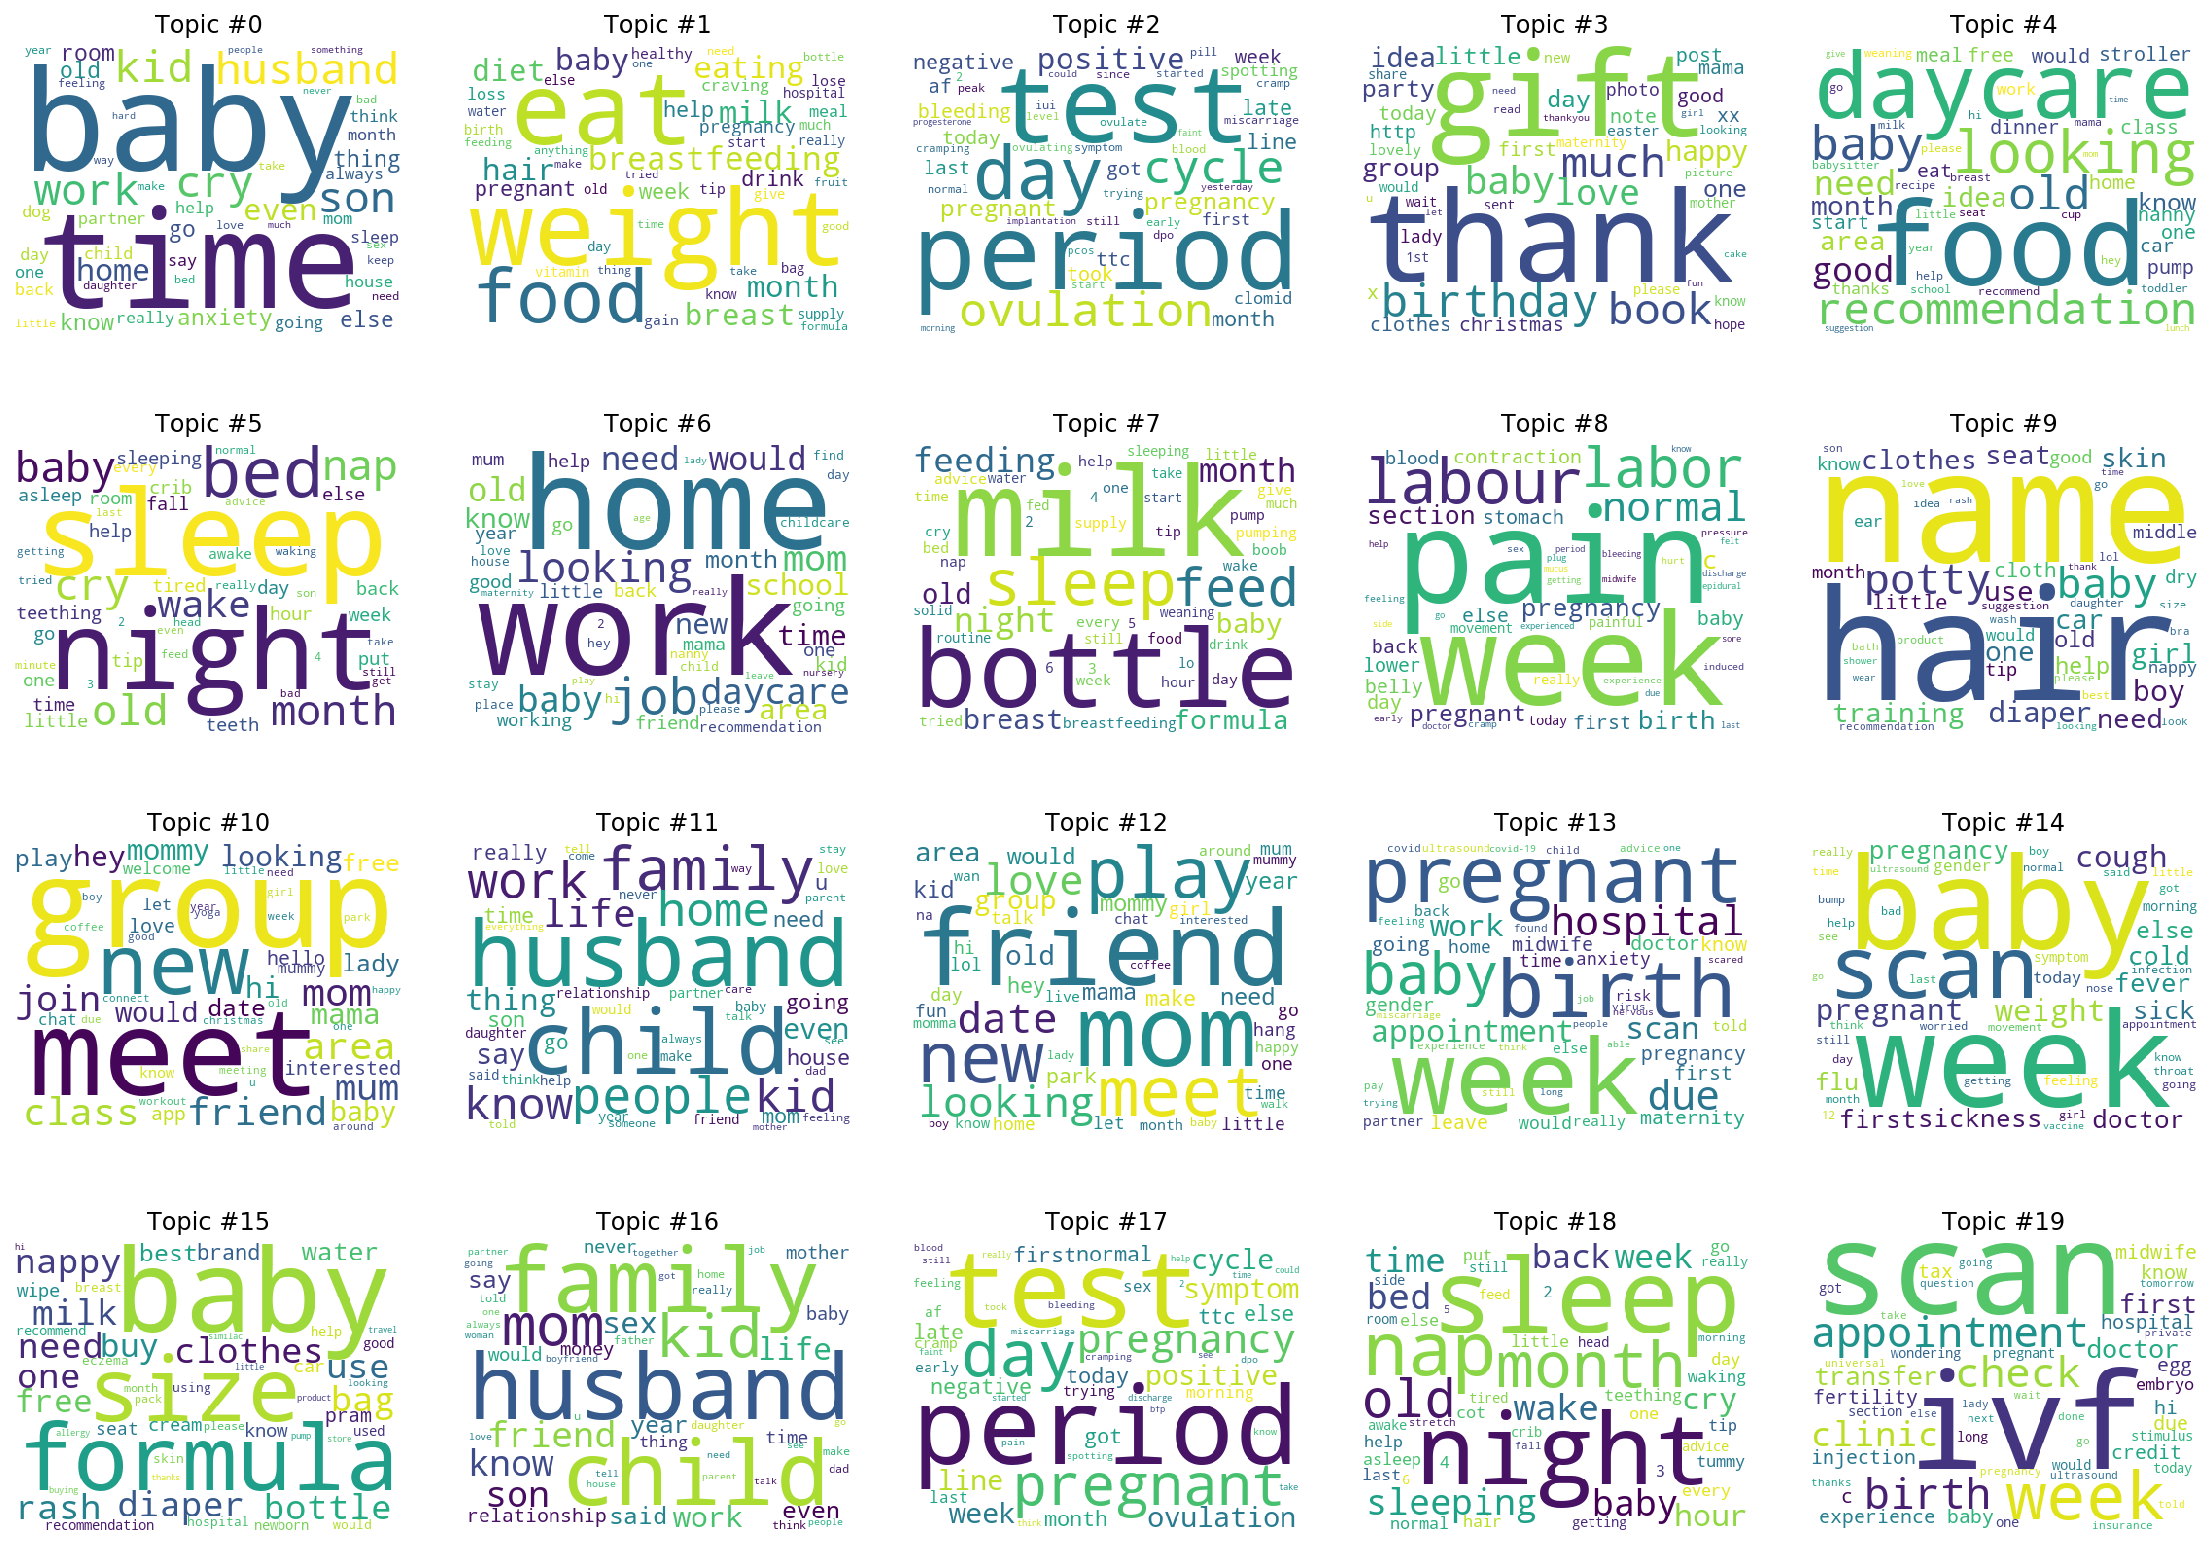

In [14]:
render_clouds(model2)

In [15]:
data = [
    eval_coherence(get_topic_words(model), gensim_dictionary, data_tokenized)
    for model in models
]

for idx, d in enumerate(data):
    print('Model %d overal coherence: %.1f%%' % (idx, 100 * d[0]))

Model 0 overal coherence: 59.2%
Model 1 overal coherence: 62.2%
Model 2 overal coherence: 60.6%


100%|██████████| 198888/198888 [00:00<00:00, 542550.75it/s]


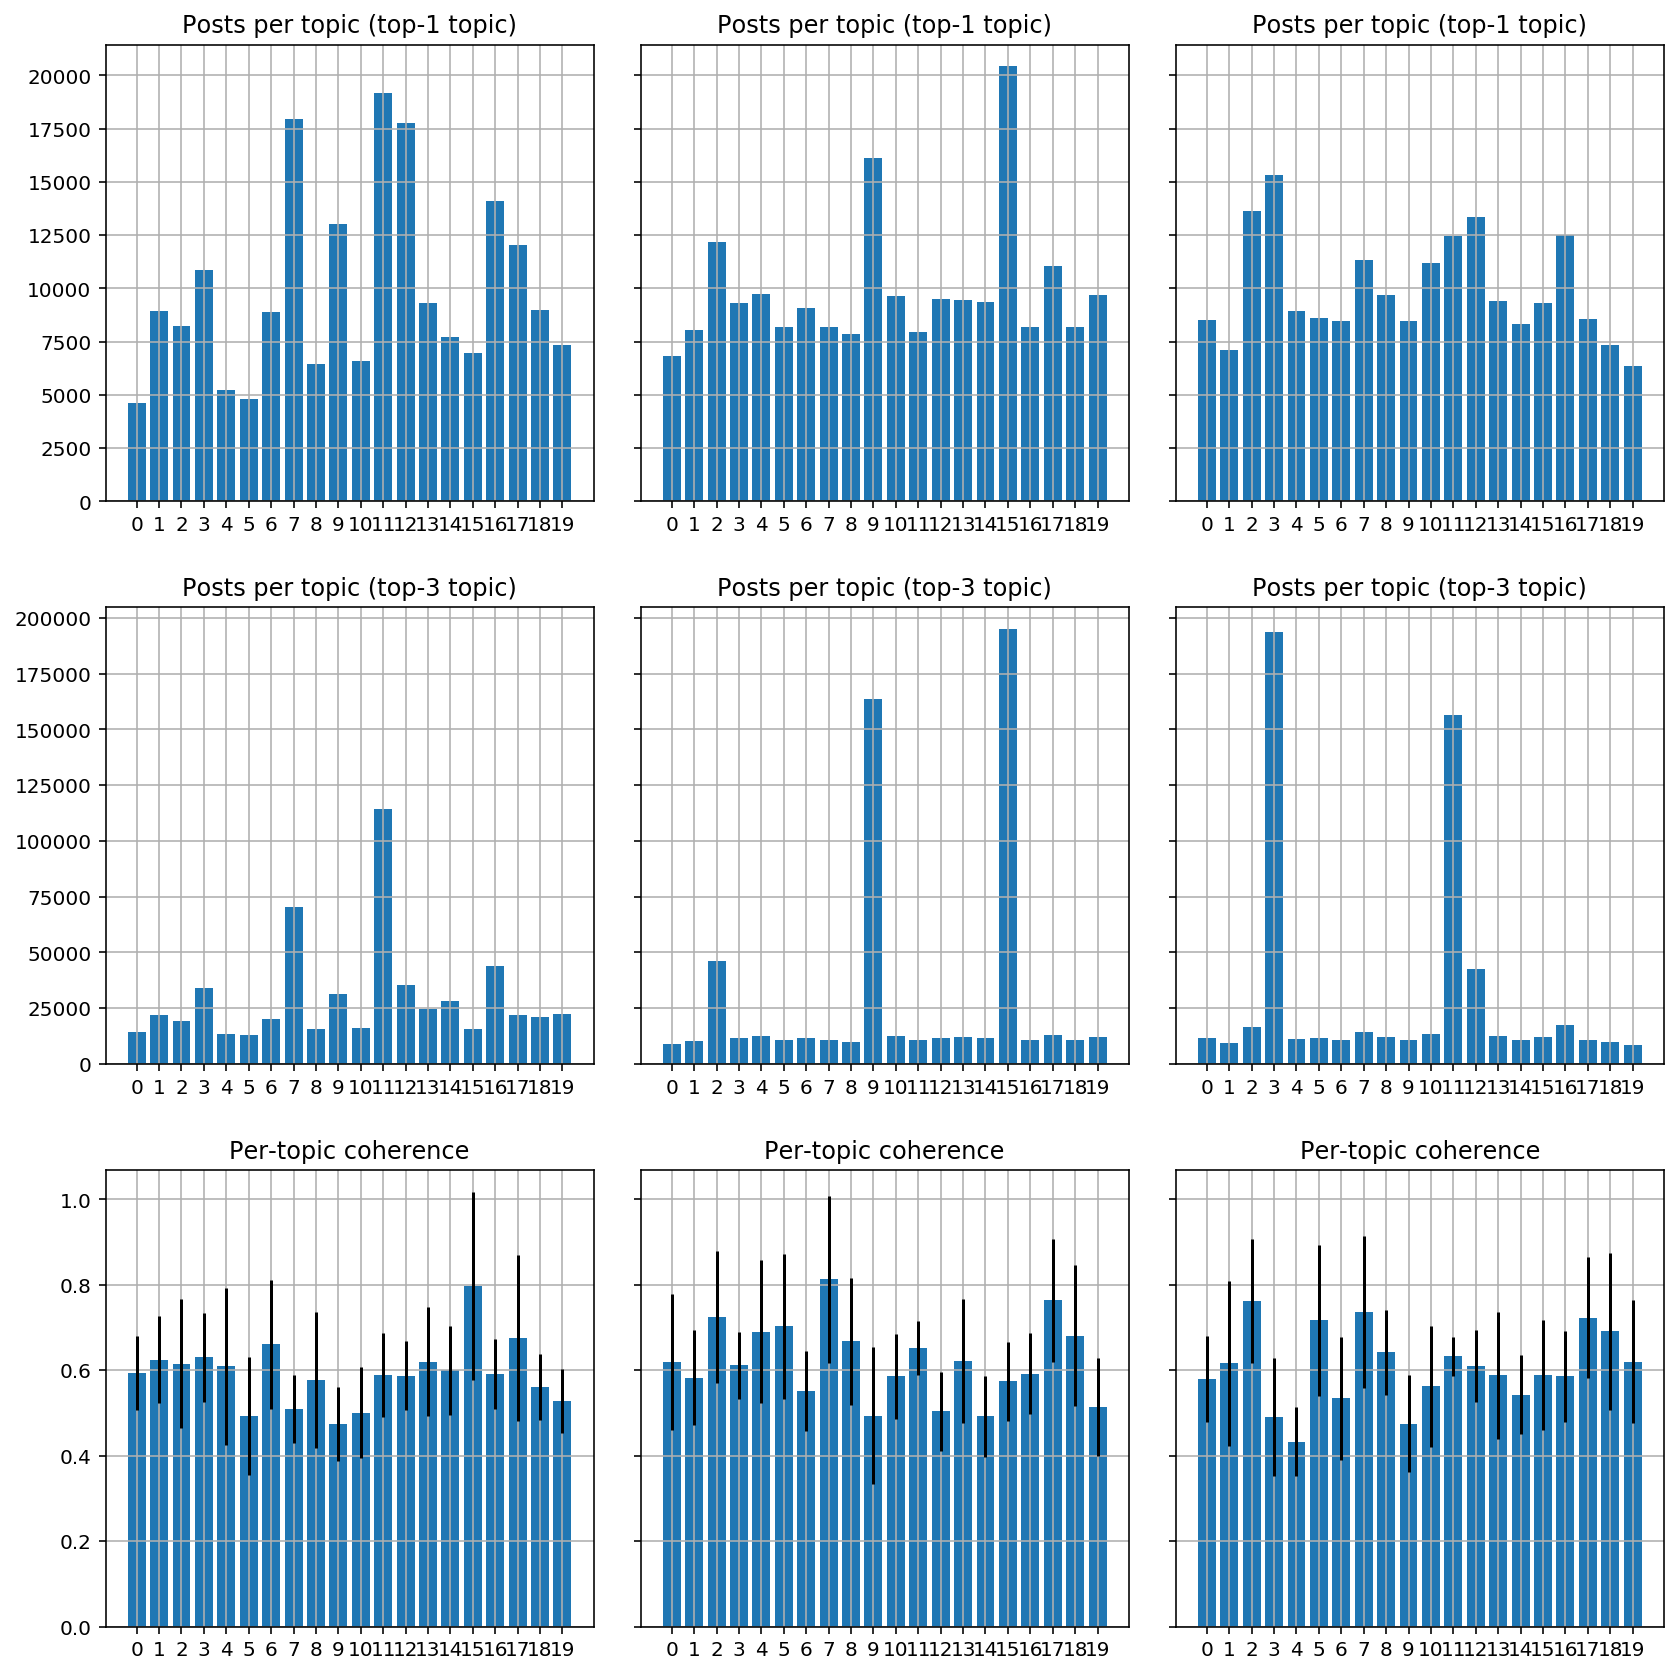

In [16]:
fig = plt.figure(figsize=(4 * len(models), 12))
axes = fig.subplots(
    nrows=3,
    ncols=len(models),
    sharey='row'
)

for idx,(d,m) in enumerate(zip(data,models)):
    plot_analysis(m, d, [a[idx] for a in axes])

fig.tight_layout(pad=2.0)
plt.show()